## **1) Initial setup**

In [5]:
#@title Install the required libs
!pip install -qq diffusers["training"]==0.3.0 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

In [179]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.7 MB/s 
     |████████████████████████████████| 2.3 MB 52.5 MB/s 
     |████████████████████████████████| 54 kB 4.2 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 212 kB 76.8 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 93.0 MB/s 
     |████████████████████████████████| 270 kB 79.8 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
     |████████████████████████████████| 80 kB 11.6 MB/s 
     |████████████████████████████████| 68 kB 8.8 MB/s 
     |████████████████████████████████| 46 kB 5.4 MB/s 
     |████████████████████████████████| 4.0 MB 76.1 MB/s 
     |████████████████████████████████| 856 kB 84

In [6]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [8]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

##**2) Settings for teaching new concept**

In [9]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

In [81]:
urls = [
    "https://miro.medium.com/max/668/1*XKea7rFWJxvWuI6bc6WYKA.jpeg",
    "https://miro.medium.com/max/668/1*uGFX567TfYJOFaoPIXZHhw.jpeg",
    "https://miro.medium.com/max/668/1*lgJCuBSl-i-VgZJDgfV7zw.jpeg",
    "https://miro.medium.com/max/668/1*cN6SXeiQpjYfINnlOZ7tFw.jpeg",
    "https://miro.medium.com/max/668/1*D7ff7KMhICd5ryB4qiw5fw.jpeg",
    "https://miro.medium.com/max/668/1*D7ff7KMhICd5ryB4qiw5fw.jpeg",
    "https://miro.medium.com/max/1000/1*PJzYXBjOgtq_AzEGD1VPRg.jpeg",
    "https://miro.medium.com/max/1000/1*YGw1uzgDQF3HoOuQlqPyAw.jpeg",


]

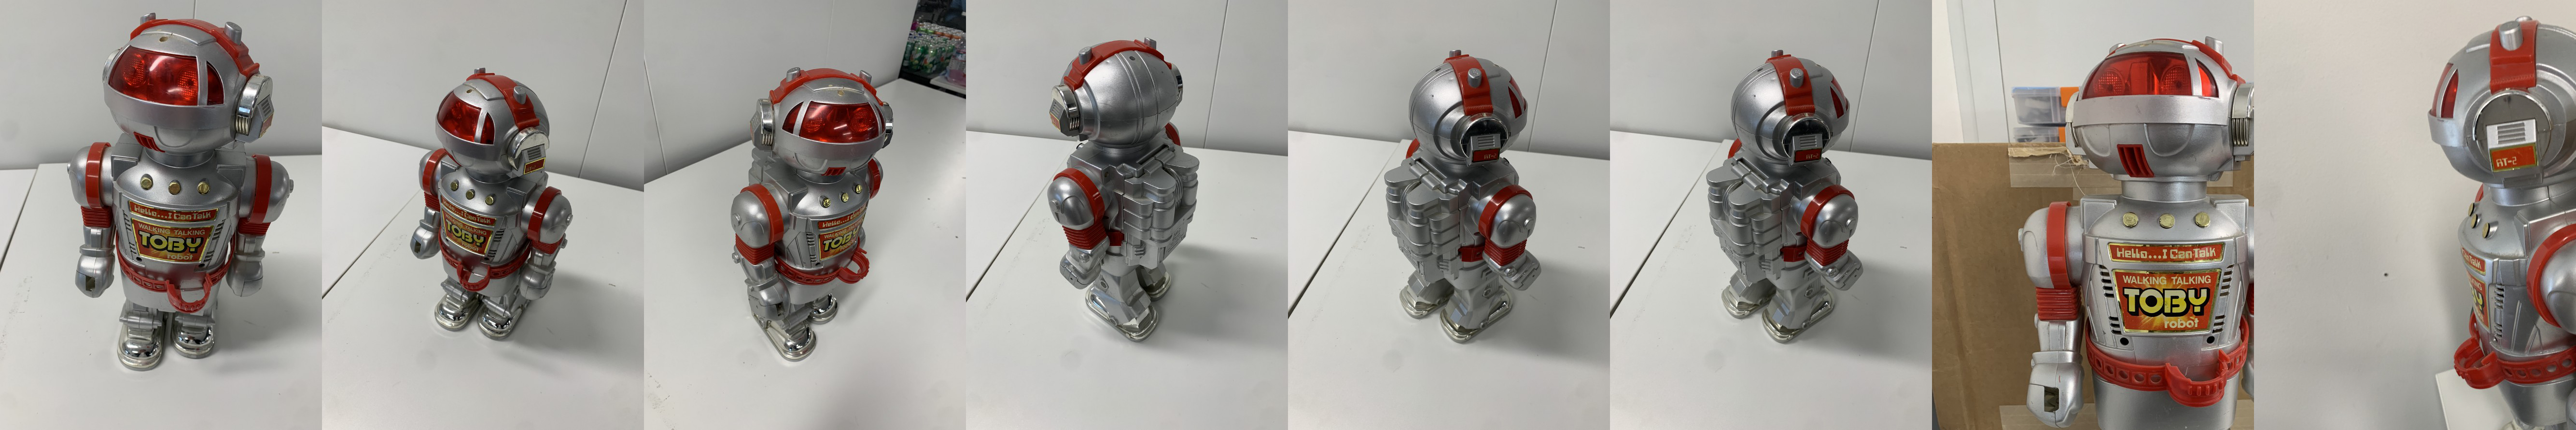

In [82]:
#@title Setup and check the images you have just added
import requests
import glob
from io import BytesIO
import time

def download_image(url):
  print("waiting")
  time.sleep(10)
  print("done")
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list()
for url in urls:
  r = requests.get(url, stream=True)
  r.raise_for_status()
  r.raw.decode_content = True  # Required to decompress gzip/deflate compressed responses.
  with Image.open(BytesIO(r.content)).convert("RGB") as img:
      img.show()
  r.close()  # Safety when stream=True ensure the connection is released.
  images.append (img)
#images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

In [58]:
#@title Settings for your newly created concept
#@markdown `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used, `style` allows you to teach the model a new style one can use.
what_to_teach = "object" #@param ["object", "style"]
#@markdown `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token = "\u003Ctoby bot>" #@param {type:"string"}
#@markdown `initializer_token` is a word that can summarise what your new concept is, to be used as a starting point
initializer_token = "toy" #@param {type:"string"}

## **3) Teach the model a new concept** (fine-tuning with textual inversion)
Execute this this sequence of cells to run the training process. The whole process may take from 1-4 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

### Create Dataset

In [117]:
#@title Setup the prompt templates for training 
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [118]:
#@title Setup the dataset
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

### Setting up the model

In [119]:
#@title Load the tokenizer and add the placeholder token as a additional special token.
#@markdown Please read and if you agree accept the LICENSE [here](https://huggingface.co/CompVis/stable-diffusion-v1-4) if you see an error
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
    use_auth_token=True,
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [120]:
#@title Get token ids for our placeholder and initializer token. This code block will complain if initializer string is not a single token
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [121]:
#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", use_auth_token=True
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae", use_auth_token=True
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", use_auth_token=True
)

We have added the `placeholder_token` in the `tokenizer` so we resize the token embeddings here, this will a new embedding vector in the token embeddings for our `placeholder_token`

In [122]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

 Initialise the newly added placeholder token with the embeddings of the initializer token

In [123]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In Textual-Inversion we only train the newly added embedding vector, so lets freeze rest of the model parameters here

In [124]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

### Creating our training data

Let's create the Dataset and Dataloader

In [125]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=512,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

In [126]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

Create noise_scheduler for training

In [127]:
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt"
)

Define hyperparameters for our training
If you are not happy with your results, you can tune the `learning_rate` and the `max_train_steps`

In [128]:
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 3000,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "seed": 42,
    "output_dir": "sd-concept-output"
}

Train!

In [129]:
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
    )

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )


    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    # Move vae and unet to device
    vae.to(accelerator.device)
    unet.to(accelerator.device)

    # Keep vae and unet in eval model as we don't train these
    vae.eval()
    unet.eval()

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
        learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
        torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))

In [130]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

Launching training on one GPU.


  0%|          | 0/3000 [00:00<?, ?it/s]

## **4) Run the code with your newly trained model**
If you have just trained your model with the code above, use the block below to run it

To save this concept for re-using, download the `learned_embeds.bin` file or save it on the library of concepts.

Use the [Stable Conceptualizer notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) for inference with persistently saved pre-trained concepts

In [131]:
#@title Set up the pipeline 
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    torch_dtype=torch.float16,
).to("cuda")

In [185]:
#@title Run the Stable Diffusion pipeline
#Don't forget to use the placeholder token in your prompt

from torch import autocast
prompt = "\u003Ctoby bot> in manga style\""
def infer(prompt):
  num_samples = 1
  num_rows = 1
  all_images = [] 
  for _ in range(num_rows):
      with autocast("cuda"):
          images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5)['sample']
          all_images.extend(images)
  return images

# grid = image_grid(all_images, num_samples, num_rows)
# grid

In [228]:
import gradio as gr
css = """
        .gradio-container {
            font-family: 'Courier New', sans-serif;
            background: #42464d;
        }
        .gr-button {
            color: white;
            border-color: black;
            background-image: linear-gradient(to right, #f6d365 0%, #fda085 51%, #f6d365 100%);
            transition-duration: 0.45s;
        }
        .gr-button:hover {
            background-image: linear-gradient(to right, white 0%, black 51%, white 100%);
            transition-duration: 0.45s;
        }
      
        .gr-Examples{
            color:white
        }
        input[type='range'] {
            accent-color: black;
        }
        .dark input[type='range'] {
            accent-color: #dfdfdf;
        }
        .container {
            max-width: 730px;
            margin: auto;
            padding-top: 1.5rem;
        }
        #gallery {
            min-height: 22rem;
            margin-bottom: 15px;
            margin-left: auto;
            margin-right: auto;
            border-bottom-right-radius: .5rem !important;
            border-bottom-left-radius: .5rem !important;
        }
        #gallery>div>.h-full {
            min-height: 20rem;
        }
        .details:hover {
            text-decoration: underline;
        }
        .footer {
            color:white;
            margin-bottom: 45px;
            margin-top: 35px;
            align: center;
            border-bottom: 1px solid #e5e5e5;
        }
        .footer>p {
            color:white;
            font-size: .8rem;
            display: inline-block;
            padding: 0 10px;
            transform: translateY(10px);
        }
        .dark .footer {
            border-color: #303030;
        }
        .dark .footer>p {
            background: #0b0f19;
        }
        .acknowledgments h4{
            margin: 1.25em 0 .25em 0;
            font-weight: bold;
            font-size: 115%;
        }
        #container-advanced-btns{
            display: flex;
            flex-wrap: wrap;
            justify-content: space-between;
            align-items: center;
        }
        }
        .gr-form{
            flex: 1 1 50%; border-top-right-radius: 0; border-bottom-right-radius: 0;
        }
        #prompt-container{
            gap: 0;
        }
        #generated_id{
            min-height: 700px
        }
        .column {
        float: left;
        width: 33.33%;
        padding: 5px;
        }

      /* Clear floats after image containers */
      .row::after {
        content: "";
        clear: both;
        display: table;
      }
"""
block = gr.Blocks(css=css)

examples = [
    [
        '<toby bot> in cartoon style'
    ],
    [
        '<toby bot> in manga style'
    ],
    [
        '<toby bot> in steampunk style'
    ],
    [
        '3d render of <toby bot>, unreal engine'
    ],
]

with block as demo:
    gr.HTML(
        """
            <div style="text-align: center; max-width: 650px; margin: 0 auto; color: white;">
              <div
                style="
                  display: inline-flex;
                  align-items: center;
                  gap: 0.8rem;
                  font-size: 1.75rem; 
                "
              >
                <img src="https://www.simpleimageresizer.com/_uploads/photos/fa5caaf6/IMG_8834-removebg-preview_15.png" />
                <h1 style="font-weight: 900; margin-bottom: 7px; color: white;">
                  Toby-Bot Diffusion Demo
                </h1>
              </div>
              <p style="margin-bottom: 10px; font-size: 94%; ">
                Toby-Bot Diffusion is an AI text to image generator that has been trained to emulate different renditions
                 of toby-bot through fine-tuning of the Stable Diffusion model. The backend is run in python on a 
                 google colab. The computing power comes from Colab Pro+ cloud computing services, which grants the backend
                 access to extremely high speed GPUs, allowing for the creation of images in just about five seconds. Feel free to
                 try the examples below or enter literally any prompt you want; the model stil incorperates everyting that
                 a regular stable diffusion model can do.
              </p>
            </div>
        """
    )
    with gr.Group():
        with gr.Box():
            with gr.Row().style(mobile_collapse=False, equal_height=False):

                text = gr.Textbox(
                    label="Enter your prompt", show_label=False, max_lines=1
                ).style(
                    border=(True, False, True, True),
                    rounded=(True, False, False, True),
                    container=False,
                )
                btn = gr.Button("Run").style(
                    margin=False,
                    rounded=(False, True, True, False),
                )
               
        gallery = gr.Gallery(label="Generated images", show_label=False, elem_id="generated_id").style(
            grid=[2], height="auto"
        )
        
        ex = gr.Examples(examples=examples, fn=infer, inputs=[text], outputs=gallery, cache_examples=True)
        ex.dataset.headers = [""]
        
        text.submit(infer, inputs=[text], outputs=gallery)
        btn.click(infer, inputs=[text], outputs=gallery)
        gr.HTML(
            """<div>
                <p style="color:white;"> Prompt: "toby bot in manga style"<br> These are some of the better images the model produced. You can really see how the model took inspiration from the images that were used to refine it.</p>
               </div>
                <div class="row">
                  
                <div class="column">
                  <img src="https://miro.medium.com/max/800/1*bsuKdAmrbrzcqgCYLrscfw.png" style="width:100%">
                </div>
                <div class="column">
                  <img src="https://miro.medium.com/max/800/1*g21EG_63vsIPINs69oiJhA.png" style="width:100%">
                </div>
               </div>

               <p style="color:white;"> Images given to the model for refinement:</p>
                <div>
                  <img src="https://miro.medium.com/max/1400/1*P7UDQtsXRUfWzNzOuk2g_w.png" style="width:200%">
               </div>
           """
        )

demo.queue(max_size=25).launch(share = True)

Caching examples at: '/content/gradio_cached_examples/476/log.csv'


/usr/local/lib/python3.7/dist-packages/gradio/layouts.py:75: UserWarning: mobile_collapse is no longer supported.
  warnings.warn("mobile_collapse is no longer supported.")
/usr/local/lib/python3.7/dist-packages/gradio/components.py:198: UserWarning: 'rounded' styling is no longer supported. To round adjacent components together, place them in a Column(variant='box').
  "'rounded' styling is no longer supported. To round adjacent components together, place them in a Column(variant='box')."
/usr/local/lib/python3.7/dist-packages/gradio/components.py:216: UserWarning: 'border' styling is no longer supported. To place adjacent components in a shared border, place them in a Column(variant='box').
  "'border' styling is no longer supported. To place adjacent components in a shared border, place them in a Column(variant='box')."
/usr/local/lib/python3.7/dist-packages/gradio/components.py:207: UserWarning: 'margin' styling is no longer supported. To place adjacent components together without 

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://721ecaa80300814a.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7fa3b2b6df90>,
 'http://127.0.0.1:7905/',
 'https://721ecaa80300814a.gradio.app')

In [184]:
#@markdown Zip your Model!!
!mkdir /content/concept_extract
!cp /content/sd-concept-output/learned_embeds.bin /content/concept_extract
!cp /content/sd-concept-output/model_index.json /content/concept_extract
!zip -r /content/concept.zip /content/concept_extract


  adding: content/concept_extract/ (stored 0%)
  adding: content/concept_extract/learned_embeds.bin (deflated 13%)
  adding: content/concept_extract/model_index.json (deflated 57%)
